In [2]:
import numpy as np

In [3]:
# Add Necessary Imports

np.random.seed(123)

# Activation Functions below
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_derivative(a):   # a = sigmoid(z)
    return a * (1 - a)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(a):      # a = tanh(z)
    return 1.0 - a**2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(a):      # a = relu(z)
    return (a > 0).astype(float)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(z, alpha=0.01):  # derivative expects z
    return np.where(z > 0, 1.0, alpha)

# Safe ELU to avoid overflow from evaluating both branches in np.where
def elu(x, alpha=1.0):
    y = x.copy()
    mask = x <= 0
    y[mask] = alpha * (np.exp(x[mask]) - 1.0)
    return y

def elu_derivative(z, alpha=1.0):
    out = np.ones_like(z)
    mask = z <= 0
    out[mask] = alpha * np.exp(z[mask])
    return out

def get_activation(name, alpha=0.01):
    if name == "sigmoid":
        f  = sigmoid
        df = lambda z, a: sigmoid_derivative(a)
    elif name == "tanh":
        f  = tanh
        df = lambda z, a: tanh_derivative(a)
    elif name == "relu":
        f  = relu
        df = lambda z, a: relu_derivative(a)      # a = relu(z)
    elif name == "leaky_relu":
        f  = lambda x: leaky_relu(x, alpha=alpha)
        df = lambda z, a: leaky_relu_derivative(z, alpha=alpha)
    elif name == "elu":
        f  = lambda x: elu(x, alpha=alpha)
        df = lambda z, a: elu_derivative(z, alpha=alpha)
    else:
        raise ValueError("Unknown activation")
    return f, df

# Recommended initialization
def recommended_std(activation, fan_in, fan_out, alpha=0.01):
    if activation == "sigmoid":          # LeCun
        return 1.0 / np.sqrt(fan_in)
    elif activation == "tanh":           # Xavier/Glorot
        return np.sqrt(2.0 / (fan_in + fan_out))
    elif activation == "relu":           # He
        return np.sqrt(2.0 / fan_in)
    elif activation == "leaky_relu":     # He adjusted for slope
        return np.sqrt(2.0 / ((1.0 + alpha**2) * fan_in))
    elif activation == "elu":            # He-like often works well
        return np.sqrt(2.0 / fan_in)
    else:
        raise ValueError("Unknown activation for init")

# Bad initialization
def bad_std(activation):
    if activation in ("sigmoid", "tanh"):
        return 1.0     # too large -> saturation -> vanishing
    if activation in ("relu", "leaky_relu", "elu"):
        return 2.0     # too large -> exploding
    return 1.0

# Code to simulate Gradient Flow in an MLP
def simulate_gradient_flow(activation, L=30, width=80, reps=8, init_std=1.0, alpha=0.01):
    """
    Builds random deep MLPs and measures the backprop gradient norm per depth.
    Returns depth array and the mean gradient norm across trials.
    """
    f, df = get_activation(activation, alpha=alpha)
    grad_norms_accum = np.zeros(L + 1)

    for _ in range(reps):
        a_list, z_list, W_list = [], [], []
        a_list.append(np.random.randn(width))  # input a^0

        # Forward
        for _l in range(L):
            W = np.random.randn(width, width) * init_std
            z = W @ a_list[-1]
            a = f(z)
            W_list.append(W); z_list.append(z); a_list.append(a)

        # Backprop: start from dL/da^L (scaled ones to keep magnitude modest)
        g_a = np.ones_like(a_list[-1]) / width
        norms = [np.linalg.norm(g_a)]

        for l in reversed(range(L)):
            g_z = g_a * df(z_list[l], a_list[l + 1])  # df uses (z, a)
            g_a = W_list[l].T @ g_z
            norms.append(np.linalg.norm(g_a))

        grad_norms_accum += np.array(norms)

    depth = np.arange(L + 1)  # 0..L (0 = at output, L = back to input)
    mean_norm = grad_norms_accum / reps
    # Avoid zeros on log plot
    mean_norm = np.clip(mean_norm, 1e-20, None)
    return depth, mean_norm

# Sample data to run the code
L         = 30
width     = 80
reps      = 8
alpha_lky = 0.01
alpha_elu = 1.0

activations = ["sigmoid", "tanh", "relu", "leaky_relu", "elu"]



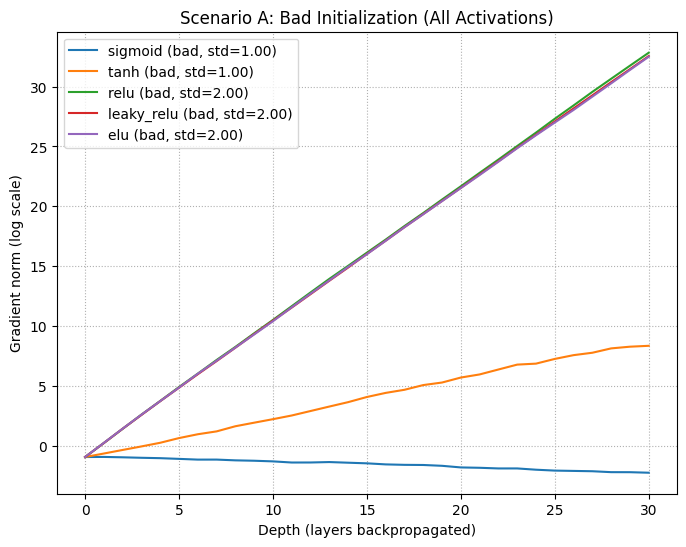

31


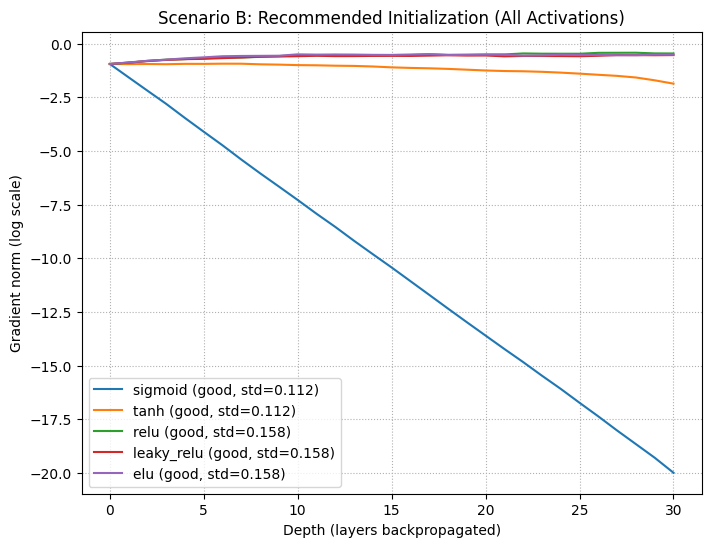

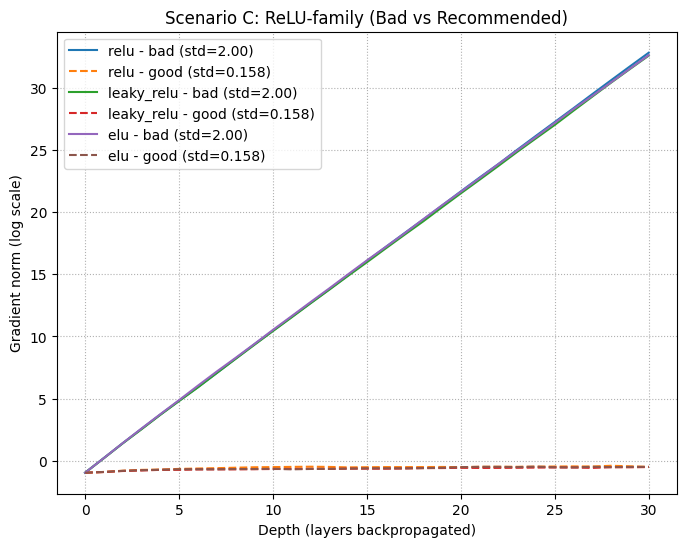

In [4]:
import matplotlib.pyplot as plt

# Scenario A:
plt.figure(figsize=(8,6))
for act in activations:
    std_bad = bad_std(act)
    depth, grad_bad = simulate_gradient_flow(
        act, L=L, width=width, reps=reps, init_std=std_bad
    )
    plt.plot(depth, np.log10(grad_bad), label=f"{act} (bad, std={std_bad:.2f})")

plt.title("Scenario A: Bad Initialization (All Activations)")
plt.xlabel("Depth (layers backpropagated)")
plt.ylabel("Gradient norm (log scale)")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.show()


# Scenario B:
plt.figure(figsize=(8,6))
for act in activations:
    std_good = recommended_std(act, fan_in=width, fan_out=width)
    depth, grad_good = simulate_gradient_flow(
        act, L=L, width=width, reps=reps, init_std=std_good
    )
    plt.plot(depth, np.log10(grad_good), label=f"{act} (good, std={std_good:.3f})")
print(len(grad_good ))
plt.title("Scenario B: Recommended Initialization (All Activations)")
plt.xlabel("Depth (layers backpropagated)")
plt.ylabel("Gradient norm (log scale)")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.show()


# Scenario C:
relu_family = ["relu", "leaky_relu", "elu"]

plt.figure(figsize=(8,6))
for act in relu_family:

    std_bad = bad_std(act)
    depth, grad_bad = simulate_gradient_flow(
        act, L=L, width=width, reps=reps, init_std=std_bad
    )
    plt.plot(depth, np.log10(grad_bad), label=f"{act} - bad (std={std_bad:.2f})")


    std_good = recommended_std(act, fan_in=width, fan_out=width)
    depth, grad_good = simulate_gradient_flow(
        act, L=L, width=width, reps=reps, init_std=std_good
    )
    plt.plot(depth, np.log10(grad_good), linestyle="--",
             label=f"{act} - good (std={std_good:.3f})")

plt.title("Scenario C: ReLU-family (Bad vs Recommended)")
plt.xlabel("Depth (layers backpropagated)")
plt.ylabel("Gradient norm (log scale)")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.show()


In [9]:
std_bad = bad_std("tanh")
print('std:-',std_bad, 'activation:- ','tanh')
depth, grad_bad = simulate_gradient_flow(
    act, L=L, width=width, reps=reps, init_std=std_bad
)
print('depth:-', depth, '\ngrad for bad std', grad_bad)

std:- 1.0 activation:-  tanh
depth:- [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] 
grad for bad std [1.11803399e-01 8.13879030e-01 5.98767544e+00 4.36481426e+01
 2.81322569e+02 2.06180376e+03 1.37845435e+04 8.80190666e+04
 5.98347524e+05 4.14947977e+06 2.57593628e+07 1.71712746e+08
 1.17200852e+09 7.63506043e+09 5.25385960e+10 3.25914498e+11
 2.03392486e+12 1.31371079e+13 8.58377684e+13 5.78199878e+14
 3.63144292e+15 2.28472812e+16 1.45217995e+17 8.70289970e+17
 5.51454441e+18 3.08231867e+19 1.99610270e+20 1.36843871e+21
 8.48070293e+21 5.68190757e+22 3.84574569e+23]


In [6]:
# 1) Print stds you're using
for act in activations:
    print(act, "bad_std =", bad_std(act),
              "recommended_std =", recommended_std(act, fan_in=width, fan_out=width))

# 2) Quick simulate and print the gradient norms (single run)
act = "relu"   # change to tanh, leaky_relu, elu as needed
std = bad_std(act)
depth, grad = simulate_gradient_flow(act, L=30, width=80, reps=8, init_std=std)
print("depth:", depth)
print("grad norms:", grad)

# 3) Inspect per-layer forward var and backward var inside simulate (small helper)
def inspect_layer_stats(activation, L=10, width=80, init_std=2.0, alpha=0.01):
    f, df = get_activation(activation, alpha=alpha)
    a = np.random.randn(width)
    print("layer\t mean(z^2)\t mean(a^2)\t mean(|g_a|)")
    W_list, z_list, a_list = [], [], [a]
    for l in range(L):
        W = np.random.randn(width, width) * init_std
        z = W @ a_list[-1]
        a = f(z)
        W_list.append(W); z_list.append(z); a_list.append(a)
    g_a = np.ones_like(a_list[-1]) / width
    for l in reversed(range(L)):
        z = z_list[l]; a = a_list[l+1]
        print(f"{L-l:2d}\t {np.mean(z**2):.2e}\t {np.mean(a**2):.2e}\t {np.mean(np.abs(g_a)):.2e}")
        g_z = g_a * df(z, a)
        g_a = W_list[l].T @ g_z

inspect_layer_stats("relu", L=12, width=80, init_std=2.0)


sigmoid bad_std = 1.0 recommended_std = 0.11180339887498948
tanh bad_std = 1.0 recommended_std = 0.11180339887498948
relu bad_std = 2.0 recommended_std = 0.15811388300841897
leaky_relu bad_std = 2.0 recommended_std = 0.1581059779071462
elu bad_std = 2.0 recommended_std = 0.15811388300841897
depth: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
grad norms: [1.11803399e-01 1.61807337e+00 2.43890908e+01 3.38764469e+02
 4.77697730e+03 6.50127744e+04 8.62314819e+05 1.13880988e+07
 1.51738926e+08 2.02640234e+09 2.62419207e+10 3.50588136e+11
 4.43887124e+12 5.86819345e+13 7.37427351e+14 1.00895213e+16
 1.21876822e+17 1.64067241e+18 2.11359457e+19 2.66792971e+20
 3.44597950e+21 4.20034030e+22 5.41250295e+23 7.14217020e+24
 9.22480059e+25 1.07850679e+27 1.34556562e+28 1.58597002e+29
 1.89342229e+30 2.41547399e+31 2.99120985e+32]
layer	 mean(z^2)	 mean(a^2)	 mean(|g_a|)
 1	 1.73e+26	 8.36e+25	 1.25e-02
 2	 1.44e+24	 4.84e+23	 1.29e-01
 3	 6.70e+21